In [1]:
from toolbox_jocha.community_detection import reorder_communities
import numpy as np
import scipy as sp

mat = np.array([[1, 2, 3, 4, 5, 6], [2, 7, 8, 9, 10, 11], [3, 8, 12, 13, 14, 15], [4, 9, 13, 16, 17, 18], [5, 10, 14, 17, 19, 20], [6, 11, 15, 18, 20, 21]])
print(mat)
print(sp.linalg.issymmetric(mat))

communities = np.array([1, 1, 2, 3, 1, 3])

x = reorder_communities(mat, communities)

print(x)
print(np.sort(communities))

[[ 1  2  3  4  5  6]
 [ 2  7  8  9 10 11]
 [ 3  8 12 13 14 15]
 [ 4  9 13 16 17 18]
 [ 5 10 14 17 19 20]
 [ 6 11 15 18 20 21]]
True
[[ 1  2  5  3  4  6]
 [ 2  7 10  8  9 11]
 [ 5 10 19 14 17 20]
 [ 3  8 14 12 13 15]
 [ 4  9 17 13 16 18]
 [ 6 11 20 15 18 21]]
[1 1 1 2 3 3]


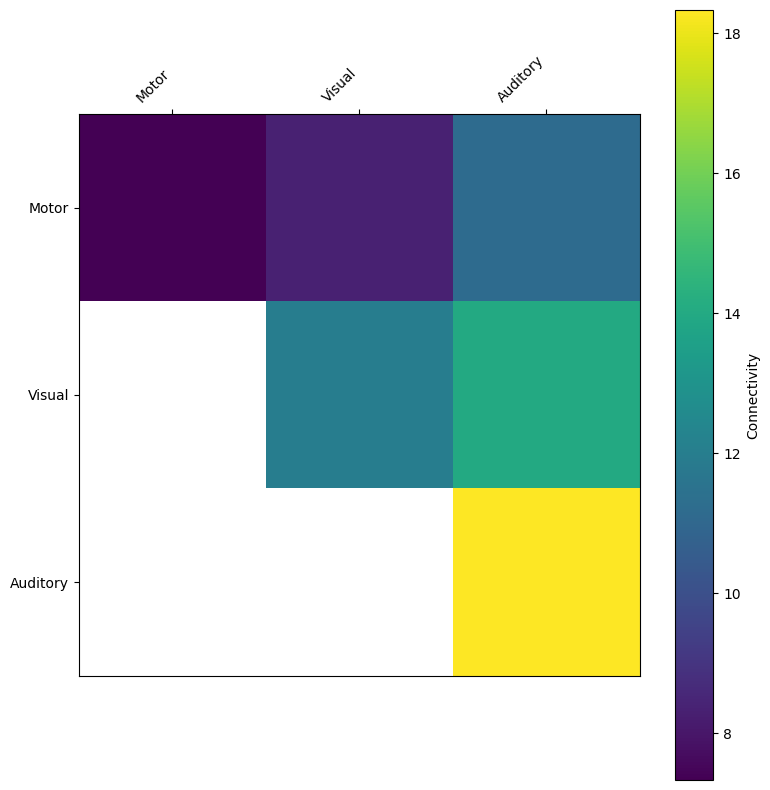

In [2]:
import matplotlib.pyplot as plt

FC_reordered = x
labels_sorted = np.sort(communities)
region_names = {"1": "Motor", "2": "Visual", "3": "Auditory"}

###############################

def plot_fc_matrix(
    FC, labels_sorted, region_names,
    triangle="full", cmap="viridis", block_average=False,
    exclude_labels=None, title=None
):
    """
    Plot a region-grouped functional connectivity (FC) matrix.

    Parameters
    ----------
    FC : (N, N) array
        Reordered FC matrix.
    labels_sorted : array of length N
        Region labels corresponding to FC rows/columns.
    region_names : dict
        Mapping from label (as str) to region name.
    triangle : {'full', 'upper', 'lower'}
        Which triangle of the matrix to show.
    cmap : str
        Matplotlib colormap.
    block_average : bool
        If True, compute region-to-region block averages
        using only the selected triangle (each element counted once).
    exclude_labels : list or set, optional
        Labels to exclude entirely from display and calculation.

    Returns
    -------
    fig : matplotlib.figure.Figure
        The figure object.
    FC_block : (M, M) ndarray, optional
        The region-averaged FC matrix (if block_average=True).
    """

    labels_sorted = np.asarray(labels_sorted)

    # --- Exclude specified labels ---
    if exclude_labels is not None:
        exclude_labels = set(exclude_labels)
        mask_keep = ~np.isin(labels_sorted, list(exclude_labels))
        FC = FC[mask_keep][:, mask_keep]
        labels_sorted = labels_sorted[mask_keep]

    n = len(labels_sorted)
    unique_labels = np.unique(labels_sorted)

    # --- Block averaging ---
    if block_average:
        FC_block = np.zeros((len(unique_labels), len(unique_labels)))
        for i, li in enumerate(unique_labels):
            mask_i = labels_sorted == li
            for j, lj in enumerate(unique_labels):
                mask_j = labels_sorted == lj

                # Select block
                block = FC[np.ix_(mask_i, mask_j)]

                # Use only selected triangle elements
                if triangle == "upper":
                    if i == j:
                        block = block[np.triu_indices_from(block)]
                    elif i > j:
                        continue
                elif triangle == "lower":
                    if i == j:
                        block = block[np.tril_indices_from(block)]
                    elif i < j:
                        continue

                FC_block[i, j] = np.nanmean(block)

        # Mask unused half for upper/lower
        if triangle == "upper":
            FC_block[np.tril_indices_from(FC_block, -1)] = np.nan
        elif triangle == "lower":
            FC_block[np.triu_indices_from(FC_block, 1)] = np.nan

        FC_plot = np.ma.masked_invalid(FC_block)

    else:
        # --- Elementwise masking ---
        mask = np.zeros_like(FC, dtype=bool)
        if triangle == "upper":
            mask[np.tril_indices(n, -1)] = True
        elif triangle == "lower":
            mask[np.triu_indices(n, 1)] = True
        elif triangle != "full":
            raise ValueError("triangle must be 'full', 'upper', or 'lower'")

        # Unmask diagonal region blocks completely
        start = 0
        for lbl in unique_labels:
            count = np.sum(labels_sorted == lbl)
            end = start + count
            mask[start:end, start:end] = False
            start = end

        FC_plot = np.ma.masked_where(mask, FC)

    # --- Plot ---
    fig, ax = plt.subplots(figsize=(8, 8))
    im = ax.imshow(FC_plot, cmap=cmap, interpolation='nearest')
    plt.colorbar(im, ax=ax, label='Connectivity')

    # Draw boundaries and tick labels
    if not block_average:
        boundaries = np.where(np.diff(labels_sorted) != 0)[0] + 1
        for b in boundaries:
            ax.axhline(b - 0.5, color='white', lw=2)
            ax.axvline(b - 0.5, color='white', lw=2)

        ticks = []
        tick_labels = []
        start = 0
        for lbl in unique_labels:
            count = np.sum(labels_sorted == lbl)
            midpoint = start + count / 2 - 0.5
            ticks.append(midpoint)
            # Always cast to str when using region_names
            tick_labels.append(region_names.get(str(int(lbl)), str(int(lbl))))
            start += count
    else:
        ticks = np.arange(len(unique_labels))
        tick_labels = [region_names.get(str(int(lbl)), str(int(lbl))) for lbl in unique_labels]

    ax.set_xticks(ticks)
    ax.set_yticks(ticks)
    ax.set_xticklabels(tick_labels, rotation=45, ha='right')
    ax.set_yticklabels(tick_labels)
    if title is not None:
        ax.set_title(title)

    # Correct axis label placement
    if triangle == "upper":
        ax.xaxis.tick_top()
        ax.xaxis.set_label_position("top")
    elif triangle == "lower":
        ax.xaxis.tick_bottom()
        ax.xaxis.set_label_position("bottom")

    plt.tight_layout()

    return (fig, FC_block) if block_average else fig

    

fig, FC_block = plot_fc_matrix(FC_reordered, labels_sorted, region_names, triangle="upper", block_average=True)

plt.tight_layout()
plt.show()

In [3]:
from toolbox_jocha.hdf5 import get_data_from_dataset
from toolbox_jocha.connectivity import bin_2d_matrix

y_binning, x_binning = 10, 10
signal_filename = f"D:/mouse_data/M365-6_v2_mvmt.h5"
dfc_filename =  f"D:/mouse_data/M365-6_v2_mvmt_GCaMP_dfc.h5"

# Load raw data and bin it with the same size as the computed dFC

GCaMP_signal, _ = get_data_from_dataset(signal_filename, f"data/3d/GCaMP")
binned_signal = bin_2d_matrix(GCaMP_signal[0,:,:], (y_binning, x_binning))
remove_indices = np.where(np.isnan(binned_signal)) # Where there are nans in the first frame of signals

del GCaMP_signal, binned_signal, _

# Load atlas flatten it and remove nans to obtain the labels array
atlas_raw, atlas_attr = get_data_from_dataset(signal_filename, f"registration/atlas")

atlas_binned = bin_2d_matrix(atlas_raw, (y_binning, x_binning), method="most_frequent")
atlas_binned[remove_indices] = np.nan

atlas_flattened = atlas_binned.flatten()
y = np.isnan(atlas_flattened)
labels_array = atlas_flattened[~y]

del atlas_raw, atlas_binned, atlas_flattened, y

# Load the regions labels and initialize a dictionary relating labels to strings

regions_list = atlas_attr["region_labels"].tolist()
regions_labels = [int(regions_list[i][0]) for i in range(len(regions_list))]
regions_dict = {str(regions_list[i][0]): str(regions_list[i][1]) for i in range(len(regions_list))}

# regions_dict = {'1': 'Motor_left', '2': 'Motor_right',
#  '3': 'Somatosensory_left', '4': 'Somatosensory_right',
#  '7': 'Visual_left', '8': 'Visual_right',
#  '9': 'Retrosplenial_left', '10': 'Retrosplenial_right'}

print(regions_dict)
                

MemoryError: Unable to allocate 328. MiB for an array with shape (1440, 247, 242) and data type float32

In [ ]:
from toolbox_jocha.community_detection import reorder_communities

def flat_to_symmetric(flat, N):
    """Convert a flattened upper triangle vector to a full symmetric matrix."""
    mat = np.zeros((N, N))
    inds = np.triu_indices(N)
    mat[inds] = flat
    mat[(inds[1], inds[0])] = flat  # Reflect upper triangle to lower
    return mat


dfc, _ = get_data_from_dataset(dfc_filename, "whole/dfc")
n_elems = dfc.shape[1]

flat_FC = np.nanmean(dfc, axis=0)

del dfc

N = int((np.sqrt(8*n_elems+1)-1)/2)
FC = flat_to_symmetric(flat_FC, N)

del flat_FC

reordered_FC = reorder_communities(FC, labels_array)

labels_sorted = np.sort(labels_array)



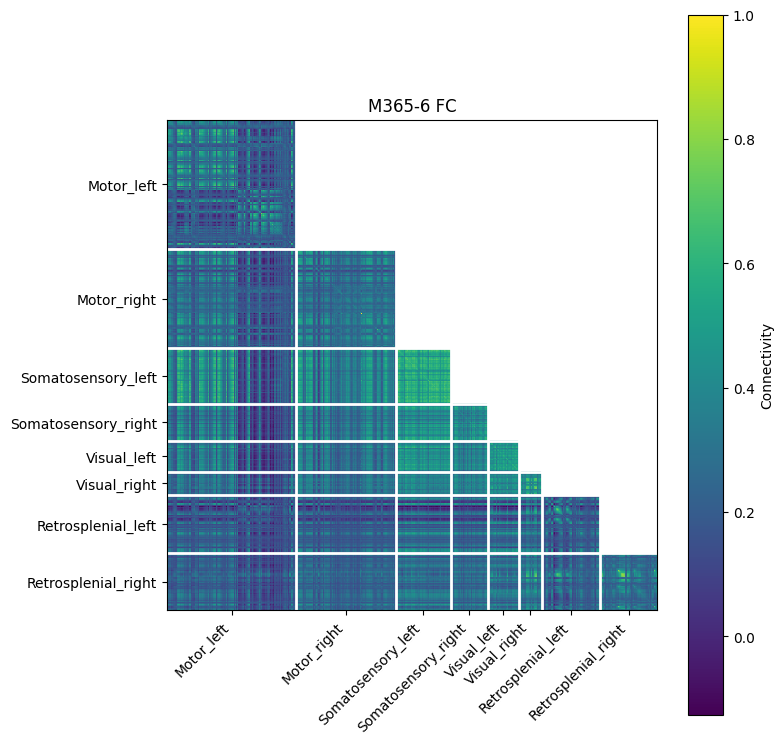

<Figure size 640x480 with 0 Axes>

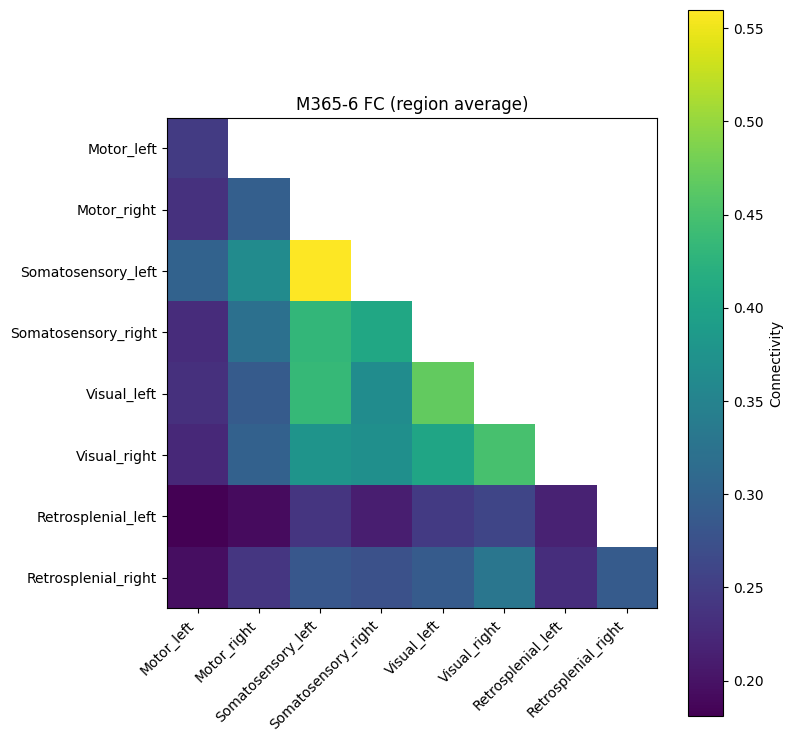

[[0.24753726        nan        nan        nan        nan        nan
         nan        nan]
 [0.23483454 0.29534889        nan        nan        nan        nan
         nan        nan]
 [0.30017723 0.3637314  0.55978201        nan        nan        nan
         nan        nan]
 [0.22951607 0.32088676 0.43148991 0.40692634        nan        nan
         nan        nan]
 [0.23379046 0.289981   0.43477815 0.36479659 0.46917046        nan
         nan        nan]
 [0.22527583 0.29797453 0.37700358 0.37035488 0.40368518 0.44923076
         nan        nan]
 [0.18102743 0.19172312 0.23909769 0.21353799 0.24562281 0.26020939
  0.2177677         nan]
 [0.1945088  0.2406272  0.28393266 0.27437435 0.29010331 0.32994155
  0.23016475 0.28971804]]


In [ ]:
fig = plot_fc_matrix(reordered_FC, labels_sorted, regions_dict, triangle="lower", block_average=False, exclude_labels=[0, 5, 6, 11, 12, 13, 14], title="M365-6 FC")
plt.show()
plt.clf()

fig, block_fc = plot_fc_matrix(reordered_FC, labels_sorted, regions_dict, triangle="upper", block_average=True, exclude_labels=[0, 5, 6, 11, 12, 13, 14], title="M365-6 FC (region average)")
plt.show()

print(block_fc)

In [ ]:
def plot_fc_from_data(flat_fc, signal_filename, params=None):

    p = {"binning": None, # in the form (y_binning, x_binning)
         "exclude_labels": [0],
         "triangle": "full", # full, lower, upper
         "block_average": False,
         "title": None}
    
    if params is not None:
        p.update(params)


    # Load raw data and bin it if needed

    GCaMP_signal, _ = get_data_from_dataset(signal_filename, f"data/3d/GCaMP")

    if p["binning"] is not None:
        binned_signal = bin_2d_matrix(GCaMP_signal[0,:,:], (p["binning"][0], p["binning"][1]))
    else:
        binned_signal = GCaMP_signal[0,:,:]

    remove_indices = np.where(np.isnan(binned_signal)) # Where there are nans in the first frame of signals

    del GCaMP_signal, binned_signal, _

    # Load atlas flatten it and remove nans to obtain the labels array
    atlas_raw, atlas_attr = get_data_from_dataset(signal_filename, f"registration/atlas")

    if p["binning"] is not None:
        atlas_binned = bin_2d_matrix(atlas_raw, (p["binning"][0], p["binning"][1]), method="most_frequent")
    else:
        atlas_binned = atlas_raw

    # Remove nan values and obtain flat labels array
    atlas_binned[remove_indices] = np.nan
    atlas_flattened = atlas_binned.flatten()

    labels_array = atlas_flattened[~np.isnan(atlas_flattened)]

    del atlas_raw, atlas_binned, atlas_flattened

    # Load the regions labels and initialize a dictionary relating labels to strings

    regions_list = atlas_attr["region_labels"].tolist()
    # regions_labels = [int(regions_list[i][0]) for i in range(len(regions_list))]
    regions_dict = {str(regions_list[i][0]): str(regions_list[i][1]) for i in range(len(regions_list))}

    N = int((np.sqrt(8*flat_fc.shape[0]+1)-1)/2)
    FC = flat_to_symmetric(flat_fc, N)

    reordered_FC = reorder_communities(FC, labels_array)
    labels_sorted = np.sort(labels_array)

    # Plot
    
    results = plot_fc_matrix(reordered_FC, labels_sorted, regions_dict, triangle=p["triangle"], block_average=p["block_average"], exclude_labels=p["exclude_labels"], title=p["title"])

    return results


In [ ]:
dfc_filename =  f"D:/mouse_data/M365-6_v2_mvmt_GCaMP_dfc.h5"
signal_filename = f"D:/mouse_data/M365-6_v2_mvmt.h5"
dfc, _ = get_data_from_dataset(dfc_filename, "whole/dfc")
n_elems = dfc.shape[1]

flat_FC = np.nanmean(dfc, axis=0)

del dfc

p = {"binning": (10, 10),
     "title": "testfig",
     "triangle": "lower",
     "block_average": True}

fig = plot_fc_from_data(flat_FC, signal_filename, params=p)